In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import seaborn as sns
from random import shuffle, randint
from tqdm import tqdm
from sklearn.neighbors import BallTree,KDTree
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import haversine_distances, euclidean_distances
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from math import radians
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
pd.set_option('display.max_columns', None)
from scipy.spatial import distance_matrix
from verstack.stratified_continuous_split import scsplit
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.inspection import permutation_importance
from pyproj import Proj, transform


from keras import Model
from tensorflow import keras
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from random import randint
from sklearn.ensemble import VotingRegressor
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from math import radians,degrees

import folium
from folium.plugins import HeatMap
import branca
import branca.colormap as cm

import pickle


Using TensorFlow backend.


In [2]:
DEPARTMENT = 'marseille'

In [3]:
df = pd.read_csv('../Datas/Processed_data/{}.csv'.format(DEPARTMENT))
df['longitude_real'] = df.longitude.apply(degrees)
df['latitude_real'] = df.latitude.apply(degrees)

In [4]:
df

id_mutation nature_mutation  valeur_fonciere  code_postal  code_commune  \
0      2014-94503           Vente         192300.0      13001.0         13201   
1      2014-94504           Vente          70000.0      13002.0         13202   
2      2014-94505           Vente          57500.0      13015.0         13215   
3      2014-94507           Vente         210000.0      13015.0         13215   
4      2014-94508           Vente         160000.0      13004.0         13204   
...           ...             ...              ...          ...           ...   
74131  2020-33330           Vente         234450.0      13011.0         13211   
74132  2020-33331           Vente         307420.0      13011.0         13211   
74133  2020-33332           Vente         107000.0      13013.0         13213   
74134  2020-33333           Vente         750000.0      13011.0         13211   
74135  2020-33342           Vente         474076.0      13011.0         13211   

       code_departement  type_local  surface_reelle_bati  \
0                    13         0.0                 76.0   
1                    13         0.0                 36.0   
2                    13         0.0                 69.0   
3                    13         1.0                 60.0   
4                    13         0.0                 78.0   
...                 ...         ...                  ...   
74131                13         0.0                 97.0   
74132                13         1.0                 78.0   
74133                13         0.0                 60.0   
74134                13         1.0                199.0   
74135                13         1.0                134.0   

       nombre_pieces_principales  surface_terrain  longitude  latitude  \
0                              3              0.0   0.094060  0.755819   
1                              1              0.0   0.093743  0.755865   
2                              3              0.0   0.093513  0.756609   
3                              3            395.0   0.093229  0.757049   
4                              3              0.0   0.094290  0.755897   
...                          ...              ...        ...       ...   
74131                          5              0.0   0.095417  0.755470   
74132                          4              0.0   0.094921  0.755566   
74133                          3              0.0   0.094934  0.756135   
74134                          5           1000.0   0.096242  0.755795   
74135                          6            613.0   0.096072  0.755635   

      type_local_str  year  quarter  month  Prix_m2_bati  Prix_m2_total  \
0        Appartement  2014        1      1   2530.263158    2530.263158   
1        Appartement  2014        1      1   1944.444444    1944.444444   
2        Appartement  2014        1      1    833.333333     833.333333   
3             Maison  2014        1      1   3500.000000     461.538462   
4        Appartement  2014        1      1   2051.282051    2051.282051   
...              ...   ...      ...    ...           ...            ...   
74131    Appartement  2020        2      5   2417.010309    2417.010309   
74132         Maison  2020        2      6   3941.282051    3941.282051   
74133    Appartement  2020        2      6   1783.333333    1783.333333   
74134         Maison  2020        2      6   3768.844221     625.521268   
74135         Maison  2020        2      6   3537.880597     634.639893   

       arrondissement  dist_min_lycee type_plus_proche_lycee  \
0                   1        0.240704                   C301   
1                   2        0.387282                   C301   
2                  15        0.246702                   C301   
3                  15        1.106154                   C302   
4                   4        0.790391                   C301   
...               ...             ...                    ...   
74131              11        0.170542                   C301   
74132     

In [5]:
# SEVERE OUTLIER, my be interesting to relaunch the NN voisinage conputation

In [6]:
df.dropna(inplace=True)
df = df[(df.Prix_m2_bati> 1000) & (df.Prix_m2_bati < 30000)].reset_index(drop=True)

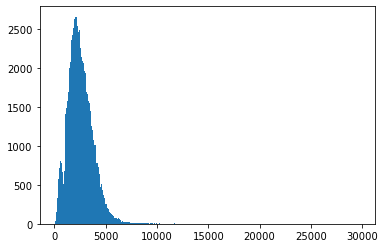

In [7]:
plt.hist(df.Prix_m2_total,bins=300);

# Adding specific datas

In fact, should be done in the produce_datasets script 

In [8]:
def add_speficic_datas(df) : 
    
    df_plages = pd.read_csv('../Datas/Raw_data/Marseille_datasets/marseille_bases_nautiques_plages_2018_vsohc0e.csv',
                    usecols=['Nom du site','Longitude','Latitude','Categorie'])
    
    df_plages.Latitude = df_plages.Latitude.apply(radians)
    df_plages.Longitude = df_plages.Longitude.apply(radians)
    
    plages = df_plages[df_plages.Categorie == 'Plages'].reset_index(drop=True)
    
    

    print("Calcul des plages les plus proches...")
    
    model = BallTree(plages[['Latitude', 'Longitude']].values, metric='haversine')
    dist, indices = model.query(df[['latitude', 'longitude']].values,5)
    dist *= 6371
    

    df['dist_min_plage'] = dist[:,0]
    df['mean_dist_2_plages'] = np.mean(dist[:,:2],axis=1)
    df['mean_dist_3_plages'] = np.mean(dist[:,:3],axis=1)
    df['mean_dist_5_plages'] = np.mean(dist[:,:5],axis=1)
    
    df['nom_plage_plus_proche'] = plages.loc[indices[:,0].squeeze(),'Nom du site'].values
    
    
    bn = df_plages[df_plages.Categorie == 'Bases nautiques'].reset_index(drop=True)
    
    

    print("Calcul de la base nautique la plus proche...")
    
    
    model = BallTree(bn[['Latitude', 'Longitude']].values, metric='haversine')
    dist, indices = model.query(df[['latitude', 'longitude']].values,1)
    dist *= 6371
    

    df['dist_min_bn'] = dist[:,0]
    
    df_parcs = pd.read_csv('../Datas/Raw_data/Marseille_datasets/marseille_parcs_jardins_2018.csv',
                    delimiter = '\t',usecols=['Nom du site','Longitude','Latitude'])
    
    df_parcs.Latitude = df_parcs.Latitude.apply(radians)
    df_parcs.Longitude = df_parcs.Longitude.apply(radians)
    
    
    print("Calcul de l'espace vert le plus proche")
    
    
    model = BallTree(df_parcs[['Latitude', 'Longitude']].values, metric='haversine')
    dist, indices = model.query(df[['latitude', 'longitude']].values,5)
    dist *= 6371
    
    df['dist_min_espace_vert'] = dist[:,0]
    df['mean_dist_5_espaces_verts'] = np.mean(dist,axis=1)
    
    
    df_monum = pd.read_csv('../Datas/Raw_data/Marseille_datasets/marseille_monuments_historiques_2018.csv',
                       delimiter = ';',usecols=['Longitude','Latitude']).dropna(subset=['Longitude','Latitude'])
    
    df_monum.Latitude = df_monum.Latitude.apply(radians)
    df_monum.Longitude = df_monum.Longitude.apply(radians)
    
    print("Calcul du monument le plus proche")
    
    
    model = BallTree(df_monum[['Latitude', 'Longitude']].values, metric='haversine')
    dist, indices = model.query(df[['latitude', 'longitude']].values,5)
    dist *= 6371
    
    df['dist_min_monument_historique'] = dist[:,0]
    df['mean_dist_5_monuments_historiques'] = np.mean(dist,axis=1)
    
    
    df_culture = pd.read_csv('../Datas/Raw_data/Marseille_datasets/marseille_lieux_culturels_2018_jrvozrd.csv',
                       delimiter = '\t',usecols=['Longitude','Latitude']).dropna(subset=['Longitude','Latitude'])
    
    df_culture.Latitude = df_culture.Latitude.apply(radians)
    df_culture.Longitude = df_culture.Longitude.apply(radians)
    
    
    print("Calcul du lieu culturel le plus proche")
    
    
    model = BallTree(df_culture[['Latitude', 'Longitude']].values, metric='haversine')
    dist, indices = model.query(df[['latitude', 'longitude']].values,5)
    dist *= 6371
    
    df['dist_min_culture'] = dist[:,0]
    df['mean_dist_5_lieux_culturels'] = np.mean(dist,axis=1)
    
    print("Now, adding economical datas about employement and demography per arrondissement...")
    # Adding pauverty for each arrondissement
    
    df_arr = pd.read_excel('../Datas/Raw_data/FILOSOFI_datasets/pauvrete_2018.xlsx')
    df_arr = df_arr[df_arr['Code géographique'].isin(df.code_commune.astype(str))].reset_index(drop=True).drop(
                    columns = ['Libellé géographique']).rename(columns = {'Code géographique' : 'code_commune'})
    
    df.code_commune = df.code_commune.astype(str)
    df = df.merge(df_arr,on='code_commune',how='left')
    
    
    
    print("Done.")
    
    
    
    return df

In [9]:
df = add_speficic_datas(df)

Calcul des plages les plus proches...
Calcul de la base nautique la plus proche...
Calcul de l'espace vert le plus proche
Calcul du monument le plus proche
Calcul du lieu culturel le plus proche
Now, adding economical datas about employement and demography per arrondissement...
Done.


In [10]:
df

id_mutation nature_mutation  valeur_fonciere  code_postal code_commune  \
0      2014-94503           Vente         192300.0      13001.0        13201   
1      2014-94504           Vente          70000.0      13002.0        13202   
2      2014-94507           Vente         210000.0      13015.0        13215   
3      2014-94508           Vente         160000.0      13004.0        13204   
4      2014-94509           Vente          90000.0      13003.0        13203   
...           ...             ...              ...          ...          ...   
70793  2020-33330           Vente         234450.0      13011.0        13211   
70794  2020-33331           Vente         307420.0      13011.0        13211   
70795  2020-33332           Vente         107000.0      13013.0        13213   
70796  2020-33333           Vente         750000.0      13011.0        13211   
70797  2020-33342           Vente         474076.0      13011.0        13211   

       code_departement  type_local  surface_reelle_bati  \
0                    13         0.0                 76.0   
1                    13         0.0                 36.0   
2                    13         1.0                 60.0   
3                    13         0.0                 78.0   
4                    13         0.0                 40.0   
...                 ...         ...                  ...   
70793                13         0.0                 97.0   
70794                13         1.0                 78.0   
70795                13         0.0                 60.0   
70796                13         1.0                199.0   
70797                13         1.0                134.0   

       nombre_pieces_principales  surface_terrain  longitude  latitude  \
0                              3              0.0   0.094060  0.755819   
1                              1              0.0   0.093743  0.755865   
2                              3            395.0   0.093229  0.757049   
3                              3              0.0   0.094290  0.755897   
4                              2              0.0   0.093912  0.756000   
...                          ...              ...        ...       ...   
70793                          5              0.0   0.095417  0.755470   
70794                          4              0.0   0.094921  0.755566   
70795                          3              0.0   0.094934  0.756135   
70796                          5           1000.0   0.096242  0.755795   
70797                          6            613.0   0.096072  0.755635   

      type_local_str  year  quarter  month  Prix_m2_bati  Prix_m2_total  \
0        Appartement  2014        1      1   2530.263158    2530.263158   
1        Appartement  2014        1      1   1944.444444    1944.444444   
2             Maison  2014        1      1   3500.000000     461.538462   
3        Appartement  2014        1      1   2051.282051    2051.282051   
4        Appartement  2014        1      1   2250.000000    2250.000000   
...              ...   ...      ...    ...           ...            ...   
70793    Appartement  2020        2      5   2417.010309    2417.010309   
70794         Maison  2020        2      6   3941.282051    3941.282051   
70795    Appartement  2020        2      6   1783.333333    1783.333333   
70796         Maison  2020        2      6   3768.844221     625.521268   
70797         Maison  2020        2      6   3537.880597     634.639893   

       arrondissement  dist_min_lycee type_plus_proche_lycee  \
0                   1        0.240704                   C301   
1                   2        0.387282                   C301   
2                  15        1.106154                   C302   
3                   4        0.790391                   C301   
4                   3        0.810458                   C302   
...               ...             ...                    ...   
70793              11        0.170542                   C301   
70794              11 

# Plot heat map of the price on the target city : 

In [11]:
# Takes a lot of memory, increase nb_plots for more details
# Static map after that

center = [43.300000, 5.400000]
nb_plots = 5e3

hmap = folium.Map(location= center, zoom_start=12)

max_price = float(df['Prix_m2_bati'].max())
min_price = float(df['Prix_m2_bati'].min())
colormap = cm.LinearColormap(colors=['blue','red'], vmin=min_price,vmax=max_price)



lat = list(df.loc[:nb_plots].latitude_real)
lon = list(df.loc[:nb_plots].longitude_real)
price = list(df.loc[:nb_plots].Prix_m2_bati)


for loc, p in tqdm(zip(zip(lat, lon), price)):
    folium.Circle(
        location=loc,
        radius=10,
        fill=True,
        color=colormap(p),
    ).add_to(hmap)
    
hmap.add_child(colormap)

display(hmap)

5001it [00:00, 42607.76it/s]


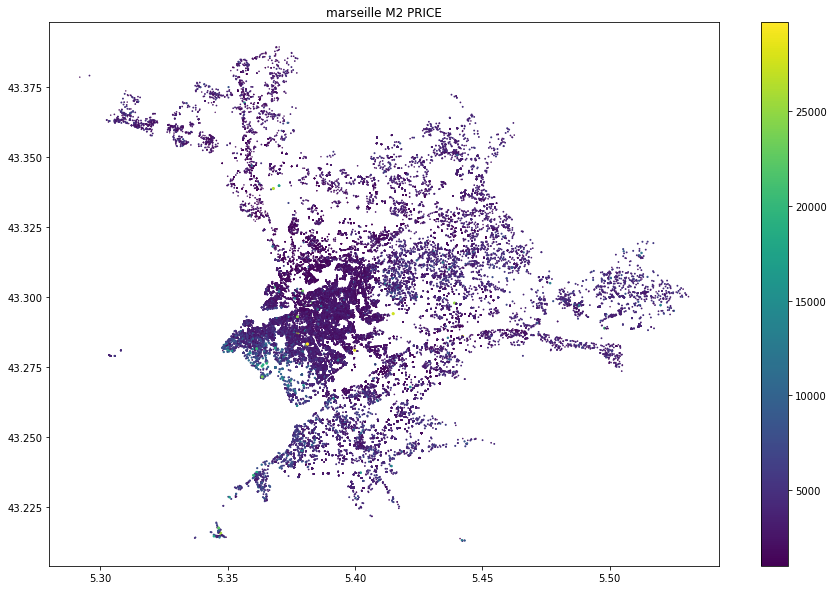

In [12]:
plt.figure(figsize = (15,10))
plt.scatter(df.longitude_real.values,df.latitude_real.values, c = df.Prix_m2_bati.values,s=5*df.Prix_m2_bati.values/df.Prix_m2_bati.values.max())
plt.colorbar()
plt.title('{} M2 PRICE'.format(DEPARTMENT))
plt.show()

In [84]:
from sklearn.metrics import mean_absolute_percentage_error
def evaluate_model(y_test,y_pred):
    error= np.abs((y_test-y_pred)/y_test)*100
    print('Mean absolute percentage error = {}'.format(mean_absolute_percentage_error(y_test,y_pred)*100))
    print('Median absolute percentage error = {}'.format(np.median(error)))

In [85]:
X_train, X_test, Y_train, Y_test = scsplit(df,df.Prix_m2_bati,test_size = 0.2,train_size = 0.8,stratify = df.valeur_fonciere,random_state=10)

In [86]:
index_train = X_train.index
index_test = X_test.index

prix_m2_train = Y_train.values
prix_m2_test = Y_test.values
vf_train = df.loc[index_train].valeur_fonciere
vf_test = df.loc[index_test].valeur_fonciere

In [87]:
categorical_features = ['nombre_pieces_principales','type_local','year','arrondissement',
                        'nom_plage_plus_proche']

quantitative_features = [
 'surface_reelle_bati',
 'surface_terrain',
 'dist_min_lycee',
 'dist_min_5_lycee',
 'dist_min_maternelle',
 'dist_min_ecoles_elementaires',
 'dist_min_colleges',
 'dist_min_5_colleges',
 'dist_min_sup',
 'dist_min_5_sup',
 'dist_min_supermarche',
 'dist_min_boulangerie',
 'dist_min_boucherie',
 'dist_min_poste',
 'dist_min_aeroport',
 'dist_min_culture',
 'dist_min_generaliste',
 'dist_min_banque',
 'dist_min_urgence',
 'dist_min_specialiste',
 'dist_min_dent',
 'dist_min_infirimier',
 'dist_min_creche',
 'dist_min_gare',
 'voisinage',
 'voisinage_total',
 'mean_dist_5_NN',
 'mean_dist_10_NN',
 'mean_dist_20_NN',
 'mean_dist_25_NN',
 'mean_dist_50_NN',
 'std_dist_5_NN',
 'std_dist_10_NN',
 'std_dist_20_NN',
 'std_dist_25_NN',
 'std_dist_50_NN',
 'dist_min_plage',
 'mean_dist_2_plages',
 'mean_dist_3_plages',
 'mean_dist_5_plages',
 'dist_min_bn',
 'dist_min_espace_vert',
 'mean_dist_5_espaces_verts',
 'dist_min_monument_historique',
 'mean_dist_5_monuments_historiques',
 'mean_dist_5_lieux_culturels',
    'Nombre de ménages fiscaux',
 'Médiane du niveau vie (€)',
 'Part des ménages fiscaux imposés (%)',
 'Taux de pauvreté-moins de 30 ans (%)',
 'Taux de pauvreté-locataires (%)',
 "Part des revenus d'activité (%)",
 'dont part des revenus des activités non salariées (%)',
 'Part des pensions, retraites et rentes (%)',
 'Part des revenus du patrimoine et autres revenus (%)',
 'dont part des prestations familiales (%)',
 'Rapport interdécile 9e décile/1er décile'
 ]


X_train = X_train[categorical_features + quantitative_features]
X_test = X_test[categorical_features + quantitative_features]

In [88]:
preprocessor = ColumnTransformer(
        [
            ("preprocessor_cat",OneHotEncoder(handle_unknown = 'ignore'),categorical_features),
            ("preprocessor_quant",StandardScaler(),quantitative_features)
            
        ], remainder = 'drop')

In [89]:
MODEL = Pipeline(
        [
            ("preprocessor",preprocessor),
            ("regressor",LGBMRegressor(learning_rate=0.2,n_estimators=1000))
        ])


In [90]:
MODEL.fit(X_train,Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['nombre_pieces_principales',
                                                   'type_local', 'year',
                                                   'arrondissement',
                                                   'nom_plage_plus_proche']),
                                                 ('preprocessor_quant',
                                                  StandardScaler(),
                                                  ['surface_reelle_bati',
                                                   'surface_terrain',
                                                   'dist_min_lycee',
                                                   'dist_min_5_lycee',
                                                   'dist_min_maternell...
         

In [91]:
predicted = MODEL.predict(X_test)
evaluate_model(Y_test,predicted)

Mean absolute percentage error = 20.232519996586042
Median absolute percentage error = 13.02775572916028


In [21]:
valeur_fonciere = vf_test
prediction_vf = predicted*X_test.surface_reelle_bati

In [22]:
evaluate_model(valeur_fonciere,prediction_vf)

Mean absolute percentage error = 20.23251999658598
Median absolute percentage error = 13.027755729160274


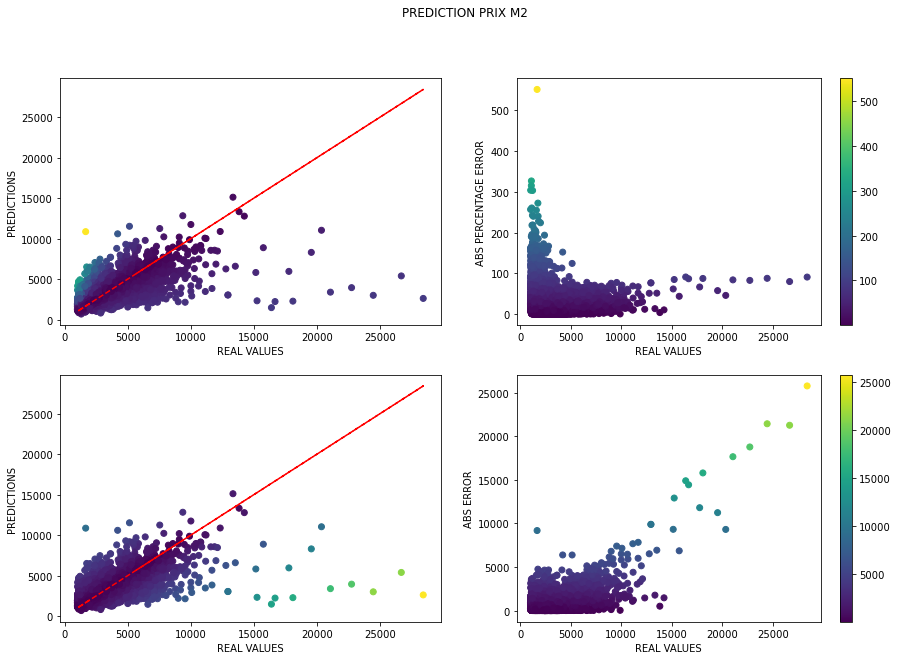

In [99]:
mape = np.abs((predicted - Y_test)/Y_test)*100

plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.scatter(Y_test,predicted,c= mape)
plt.plot(Y_test,Y_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(2,2,2)
mape = np.abs((predicted - Y_test)/Y_test)*100
plt.scatter(Y_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')

plt.colorbar()


mae = np.abs(predicted - Y_test)

plt.subplot(2,2,3)
plt.scatter(Y_test,predicted,c= mae)
plt.plot(Y_test,Y_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(2,2,4)
plt.scatter(Y_test,mae,c= mae)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS ERROR')



plt.suptitle('PREDICTION PRIX M2')
plt.colorbar()

Mean absolute percentage error = 19.704471325944308
Median absolute percentage error = 13.59427051985025


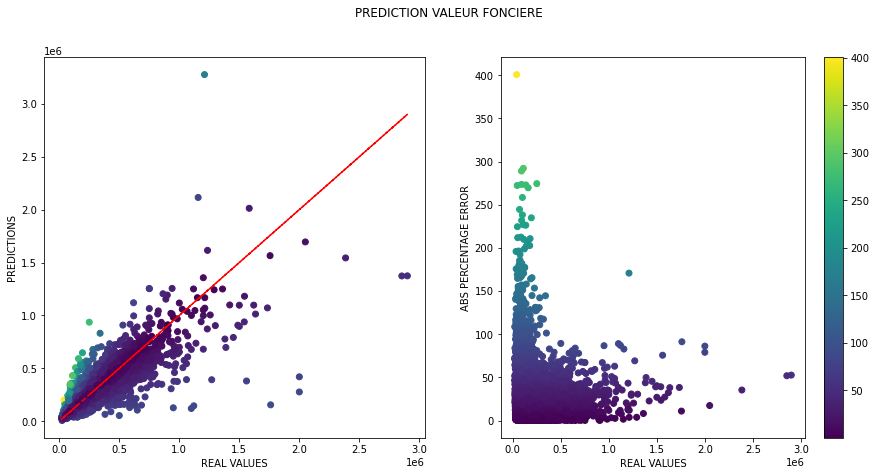

In [95]:
mape = np.abs((valeur_fonciere - prediction_vf)/valeur_fonciere)*100

evaluate_model(valeur_fonciere,prediction_vf)

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(valeur_fonciere,prediction_vf,c= mape)
plt.plot(valeur_fonciere,valeur_fonciere,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)

plt.scatter(valeur_fonciere,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION VALEUR FONCIERE')
plt.colorbar()

# Spatial distribution of the error : 

In [25]:
error = mape

hmap = folium.Map(location= center, zoom_start=10)

df_test = df[df.index.isin(index_test)] 
nb_plots = 1e3

max_error = max(error)
min_error = min(error)
mean_error = np.mean(error)
med_error = np.median(error)
colormap = cm.LinearColormap(colors=['lightblue','red'], index = [min_error,max_error],
                             vmin=min_error,vmax=max_error)



lat = list(df_test.reset_index().loc[:nb_plots].latitude_real)
lon = list(df_test.reset_index().loc[:nb_plots].longitude_real)
price = list(error)


for loc, p in tqdm(zip(zip(lat, lon), error)):
    folium.Circle(
        location=loc,
        radius=p,
        fill=True,
        color=colormap(p),
        fill_opacity=p/max_error).add_to(hmap)
    
hmap.add_child(colormap)

display(hmap)

1001it [00:00, 43500.99it/s]


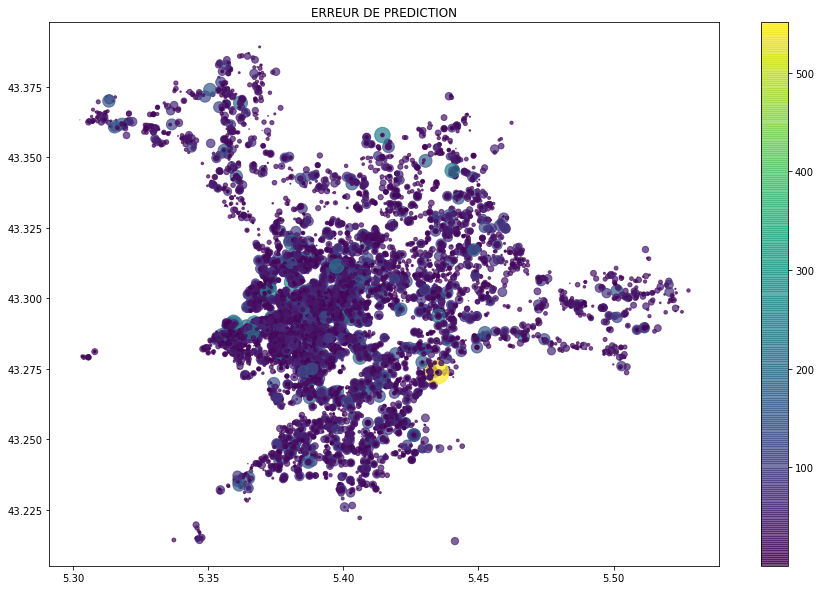

In [26]:
plt.figure(figsize = (15,10))
plt.scatter(df_test.longitude_real.values,df_test.latitude_real.values, c = error,s=error,alpha=0.7)
plt.colorbar()
plt.title('ERREUR DE PREDICTION')
plt.show()

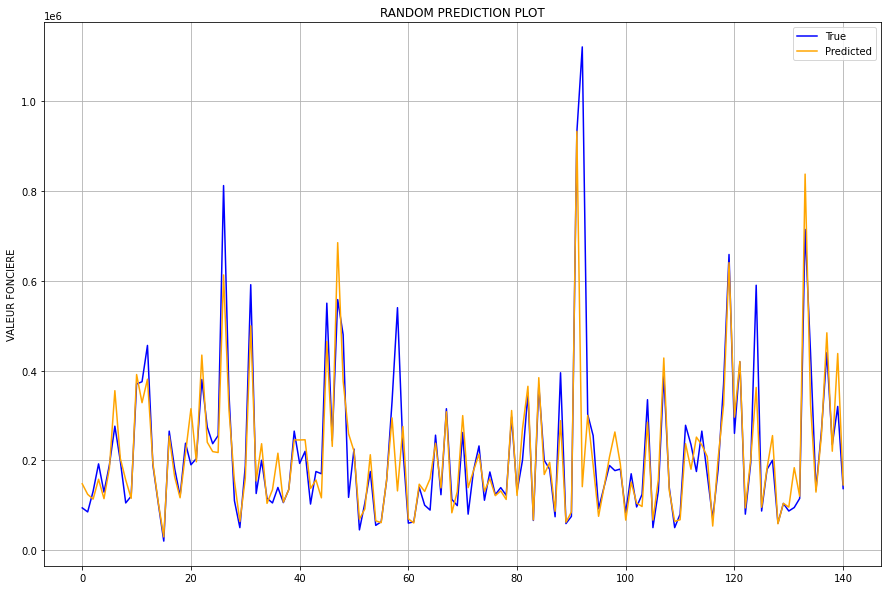

In [27]:
plt.figure(figsize=(15,10))
n = len(Y_test)
number = int(n/100)
array = np.arange(n)
shuffle(array)

i = randint(0,n-number)

prediction = prediction_vf
prediction_plot = []
true_plot = []

for indice in array[i:i+number]:
    true_plot.append(valeur_fonciere.values[indice])
    prediction_plot.append(prediction.values[indice])
    

plt.plot(range(number),true_plot,'b',label='True')
plt.plot(range(number),prediction_plot,'orange',label='Predicted')
plt.grid()
plt.title('RANDOM PREDICTION PLOT')
plt.ylabel('VALEUR FONCIERE')
plt.legend()

In [28]:
n_repeats = 5

feature_importances = permutation_importance(
    MODEL, X_test, Y_test, n_repeats=n_repeats
)

In [29]:
sorted_idx = feature_importances.importances_mean.argsort()[::-1]
names = X_test.columns.copy()

for i in range(len(names)):
    features = feature_importances.importances[sorted_idx].T[:,i]
    series = pd.Series(features)
    if i == 0 :
        dfa = pd.DataFrame(series,columns = ['Importance'])
        dfa['Features'] = np.array(names)[sorted_idx][i]
    else : 
        df2 = pd.DataFrame(series,columns = ['Importance'])
        df2['Features'] = np.array(names)[sorted_idx][i]
        dfa = pd.concat([dfa,df2])

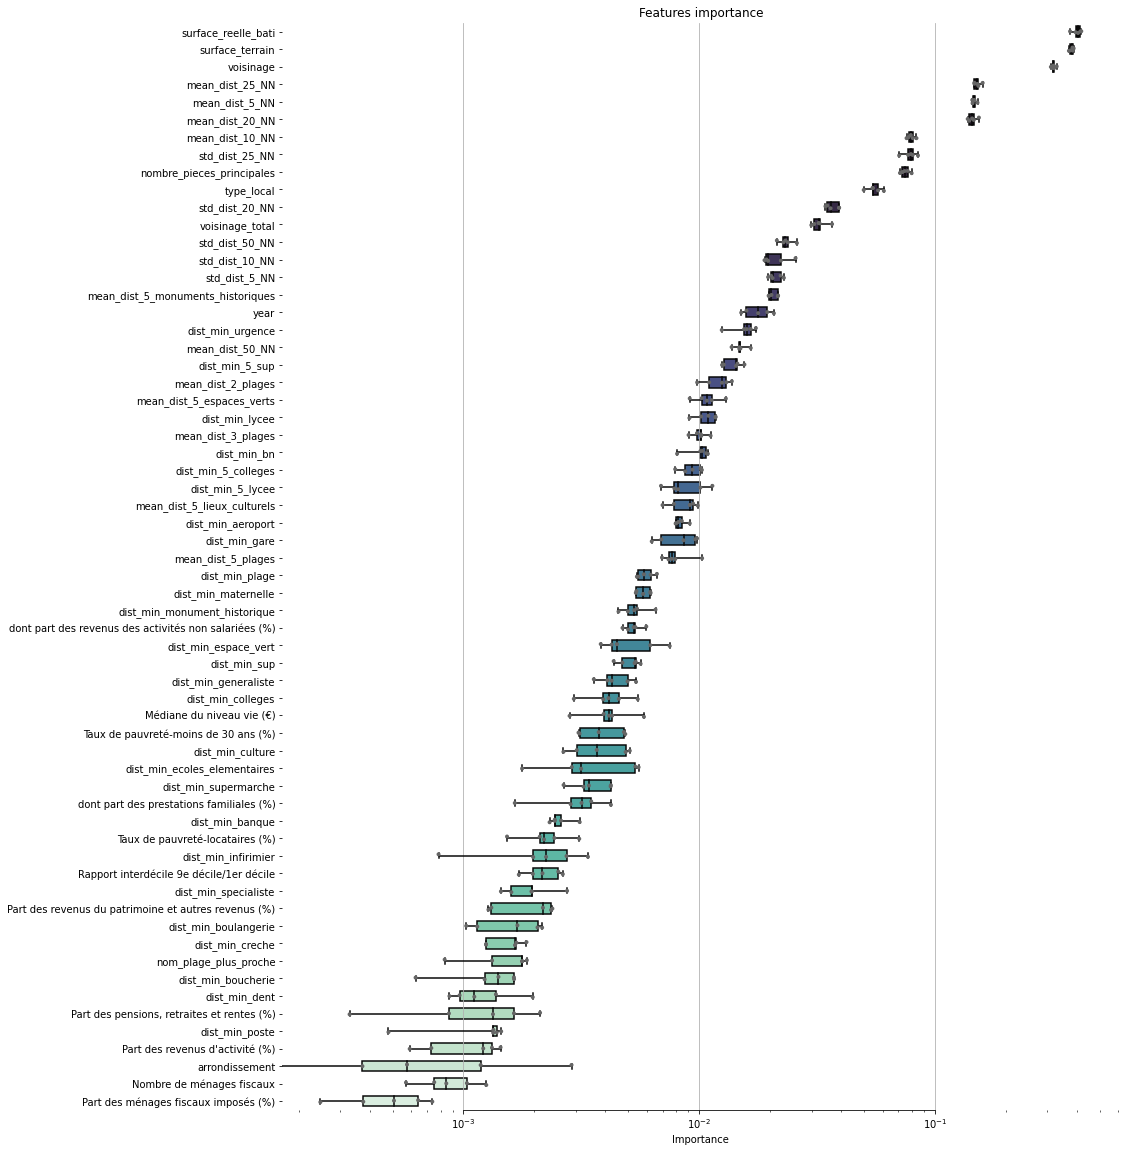

In [30]:
# Plot the orbital period with horizontal boxes

f, ax = plt.subplots(figsize=(15,20))
ax.set_xscale("log")
sns.boxplot(x='Importance', y='Features',data=dfa,
            whis=[0, 100], width=.6, palette="mako")


sns.stripplot(x='Importance', y='Features',data=dfa,
              size=4, color=".4", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
ax.set_title('Features importance');

# Neural Network

In [31]:
X_pre_train = X_train.copy()
X_pre_test = X_test.copy()
Y_train = prix_m2_train
Y_test = prix_m2_test

In [32]:
X_train_keras = preprocessor.transform(X_pre_train[categorical_features + quantitative_features])
X_test_keras = preprocessor.transform(X_pre_test[categorical_features + quantitative_features])

In [33]:
callback = EarlyStopping(patience=15,restore_best_weights = True)

In [34]:
# Decalaration of our neural network architechture. We use batchnormalization layers as well 
# as dropout to prevent overfitting
def create_network():
    model = Sequential()
    model.add(Dense(16, activation='relu',input_shape = (X_train_keras.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32, activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

    return model

In [35]:
keras_regressor = KerasRegressor(build_fn=create_network, epochs=1500,verbose=1,batch_size = 128)

In [36]:
keras_regressor.fit(X_train_keras,Y_train,callbacks=[callback],validation_split=0.2)

Train on 45310 samples, validate on 11328 samples
Epoch 1/1500
45310/45310 [==============================] - 1s 18us/step - loss: 1270.6633 - val_loss: 650.4195
Epoch 2/1500
45310/45310 [==============================] - 1s 14us/step - loss: 636.9855 - val_loss: 593.8928
Epoch 3/1500
45310/45310 [==============================] - 1s 15us/step - loss: 612.6428 - val_loss: 583.2357
Epoch 4/1500
45310/45310 [==============================] - 1s 14us/step - loss: 604.1653 - val_loss: 580.6443
Epoch 5/1500
45310/45310 [==============================] - 1s 14us/step - loss: 598.8724 - val_loss: 576.5623
Epoch 6/1500
45310/45310 [==============================] - 1s 13us/step - loss: 594.4129 - val_loss: 570.6539
Epoch 7/1500
45310/45310 [==============================] - 1s 14us/step - loss: 589.6802 - val_loss: 572.2918
Epoch 8/1500
45310/45310 [==============================] - 1s 13us/step - loss: 587.0088 - val_loss: 564.2057
Epoch 9/1500
45310/45310 [==============================] - 1

Epoch 74/1500
45310/45310 [==============================] - 1s 15us/step - loss: 548.2271 - val_loss: 541.4145
Epoch 75/1500
45310/45310 [==============================] - 1s 14us/step - loss: 546.6256 - val_loss: 541.7496
Epoch 76/1500
45310/45310 [==============================] - 1s 14us/step - loss: 546.3677 - val_loss: 540.2488
Epoch 77/1500
45310/45310 [==============================] - 1s 14us/step - loss: 546.5512 - val_loss: 540.1335
Epoch 78/1500
45310/45310 [==============================] - 1s 14us/step - loss: 546.4724 - val_loss: 544.7973
Epoch 79/1500
45310/45310 [==============================] - 1s 14us/step - loss: 547.4136 - val_loss: 540.2826
Epoch 80/1500
45310/45310 [==============================] - 1s 14us/step - loss: 545.7665 - val_loss: 540.1416
Epoch 81/1500
45310/45310 [==============================] - 1s 14us/step - loss: 544.8576 - val_loss: 541.7916
Epoch 82/1500
45310/45310 [==============================] - 1s 14us/step - loss: 546.0851 - val_loss: 5

In [37]:
prediction = keras_regressor.predict(X_test_keras)
evaluate_model(prediction,Y_test)

14160/14160 [==============================] - 0s 6us/step
Mean absolute percentage error = 19.926257230069172
Median absolute percentage error = 13.721629850808064


In [38]:
prediction_vf = prediction*X_test.surface_reelle_bati
evaluate_model(prediction_vf,vf_test)

Mean absolute percentage error = 19.926257230069247
Median absolute percentage error = 13.721629850808068


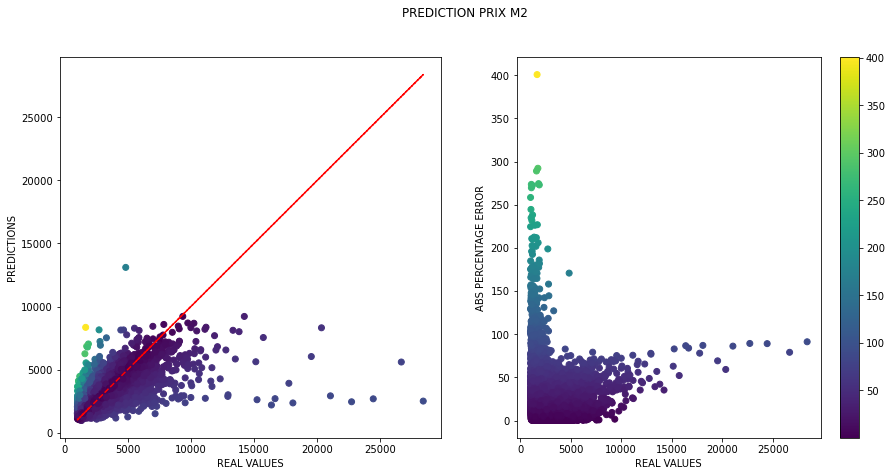

In [59]:
mape = np.abs((Y_test-prediction)/Y_test)*100

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(Y_test,prediction,c= mape)
plt.plot(Y_test,Y_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)
mape = np.abs((prediction - Y_test)/Y_test)*100
plt.scatter(Y_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION PRIX M2')
plt.colorbar()

In [61]:
(5000 - 25000)/5000

-4.0

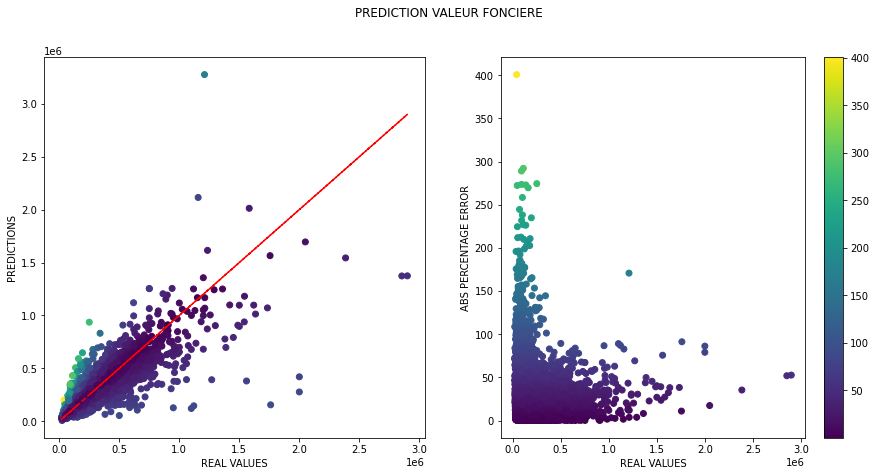

In [40]:
mape = np.abs((vf_test - prediction_vf)/vf_test)*100

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(vf_test,prediction_vf,c= mape)
plt.plot(vf_test,vf_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)

plt.scatter(vf_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION VALEUR FONCIERE')
plt.colorbar();

# MIXED MODEL 

In [41]:
mixed = np.average([prediction,predicted],axis=0,weights=[0.5,0.5])
evaluate_model(mixed,Y_test)

Mean absolute percentage error = 18.606224729229897
Median absolute percentage error = 12.912971028692134


In [42]:
part_keras = np.linspace(0,1,101)
list_mape = []
min_loss = np.inf 
best_tradeoff = 0
best_mixed = mixed

for i in part_keras : 
    mixed = np.average([prediction,predicted],axis=0,weights=[i,1-i])
    mae = np.mean(np.abs(mixed-Y_test))
    list_mape.append(mae)
    if mae < min_loss : 
        best_tradeoff = i 
        min_loss = mae
        best_mixed = mixed
        

Text(0.5, 1.0, 'BEST PART KERAS : 0.47000000000000003')

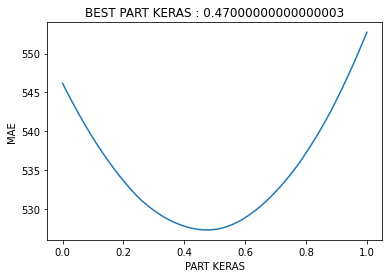

In [43]:
plt.figure()
plt.plot(part_keras,list_mape)
plt.ylabel('MAE')
plt.xlabel('PART KERAS')
plt.title('BEST PART KERAS : {}'.format(best_tradeoff))

In [44]:
evaluate_model(best_mixed,Y_test)

Mean absolute percentage error = 18.58513770861595
Median absolute percentage error = 12.909049709598676


In [58]:
Boundary = 20

ap_error = (np.abs(Y_test-best_mixed)/Y_test)*100
print("Prediction with less than {}% error represents {}% of predictions.".format(Boundary,(1 - (len(Y_test) - sum(ap_error < Boundary))/len(Y_test))*100))

Prediction with less than 20% error represents 67.62005649717514% of predictions.


# Make the true training of the two models, save optimal tradeoff

In [46]:
X = df[categorical_features + quantitative_features]
Y = df.Prix_m2_bati

In [47]:
preprocessor = ColumnTransformer(
        [
            ("preprocessor_cat",OneHotEncoder(handle_unknown = 'ignore'),categorical_features),
            ("preprocessor_quant",StandardScaler(),quantitative_features)
            
        ], remainder = 'drop')

In [48]:
MODEL = Pipeline(
        [
            ("preprocessor",preprocessor),
            ("regressor",LGBMRegressor(learning_rate=0.2,n_estimators=1000))
        ])

In [49]:
MODEL.fit(X,Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['nombre_pieces_principales',
                                                   'type_local', 'year',
                                                   'arrondissement',
                                                   'nom_plage_plus_proche']),
                                                 ('preprocessor_quant',
                                                  StandardScaler(),
                                                  ['surface_reelle_bati',
                                                   'surface_terrain',
                                                   'dist_min_lycee',
                                                   'dist_min_5_lycee',
                                                   'dist_min_maternell...
         

In [50]:
X_keras = preprocessor.transform(X)

In [51]:
callback = EarlyStopping(patience=15,restore_best_weights = True)

In [52]:
# Decalaration of our neural network architechture. We use batchnormalization layers as well 
# as dropout to prevent overfitting
def create_network():
    model = Sequential()
    model.add(Dense(16, activation='relu',input_shape = (X_keras.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32, activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

    return model

In [53]:
keras_regressor = KerasRegressor(build_fn=create_network, epochs=1500,verbose=1,batch_size = 128)

In [54]:
keras_regressor.fit(X_keras,Y,callbacks=[callback],validation_split=0.2)

Train on 56638 samples, validate on 14160 samples
Epoch 1/1500
56638/56638 [==============================] - 1s 17us/step - loss: 1110.9650 - val_loss: 721.0291
Epoch 2/1500
56638/56638 [==============================] - 1s 14us/step - loss: 602.7089 - val_loss: 693.8262
Epoch 3/1500
56638/56638 [==============================] - 1s 14us/step - loss: 589.1372 - val_loss: 693.4932
Epoch 4/1500
56638/56638 [==============================] - 1s 14us/step - loss: 581.9853 - val_loss: 689.5229
Epoch 5/1500
56638/56638 [==============================] - 1s 14us/step - loss: 576.9903 - val_loss: 705.0486
Epoch 6/1500
56638/56638 [==============================] - 1s 14us/step - loss: 571.8953 - val_loss: 682.8092
Epoch 7/1500
56638/56638 [==============================] - 1s 14us/step - loss: 568.5876 - val_loss: 703.6010
Epoch 8/1500
56638/56638 [==============================] - 1s 13us/step - loss: 565.7225 - val_loss: 680.1747
Epoch 9/1500
56638/56638 [==============================] - 1

# Saving models

In [55]:
filename = './models/Pipeline_LGBM_{}.sav'.format(DEPARTMENT)
pickle.dump(MODEL, open(filename, 'wb'))

In [56]:
filename = './models/preprocessor_keras_{}.sav'.format(DEPARTMENT)
pickle.dump(preprocessor, open(filename, 'wb'))

In [57]:
filename = './models/keras_{}.h5'.format(DEPARTMENT)
keras_regressor.model.save(filename)